# This is just a playground for me 

In [51]:
import random, cv2
import mediapipe as mp
import tensorflow as tf 
from warnings import filterwarnings
filterwarnings("ignore") 
tf.config.run_functions_eagerly(True)
from tensorflow.keras.callbacks import ReduceLROnPlateau

def _shift(X):
        
        X = tf.Variable(X, dtype = tf.float32)
        
        X_locations = X[:, :2] 
        Y_locations = X[:, 2:4] 
        Z_locations = X[:, 4:6]
        
        mask = tf.not_equal(Y_locations, 0) 
        nonzero_Y_locations = tf.boolean_mask(Y_locations, mask) # contains all nonzero elements of Y_locations 
    
        maximum = tf.math.reduce_max(nonzero_Y_locations)
        minimum = tf.math.reduce_min(nonzero_Y_locations)

        can_move_up = 1 - maximum 
        can_move_down = minimum 
        mask = tf.cast(mask, tf.float32)
    
        if tf.random.uniform((1,)) > 0.5: 
            move_up = tf.random.uniform((1,), 0, can_move_up)
            X[:, 2:4].assign(X[:, 2:4] + mask * tf.ones_like(X[:, 2:4]) * move_up)
        else: 

            move_down = tf.random.uniform((1,), 0, can_move_down)
            X[:, 2:4].assign(X[:, 2:4] - mask * tf.ones_like(X[:, 2:4]) * move_down)

        mask = tf.not_equal(X_locations, 0) 
        nonzero_X_locations = tf.boolean_mask(X_locations, mask) 

        maximum = tf.math.reduce_max(nonzero_X_locations)
        minimum = tf.math.reduce_min(nonzero_X_locations)
            
        can_move_right = 1- maximum
        can_move_left = minimum 
        mask = tf.cast(mask, tf.float32)

        if tf.random.uniform((1,)) > 0.5: 
            #print("right")
            # move right
            move_right = tf.random.uniform((1,), 0, can_move_right)
            X[:, :2].assign(X[:, :2] + mask * tf.ones_like(X[:, :2]) * move_right)

        else: 
            # move left 
            move_left = tf.random.uniform((1,), 0, can_move_left)
            X[:, :2].assign(X[:, :2] - mask * tf.ones_like(X[:, :2]) * move_left)

        mask = tf.not_equal(Z_locations, 0) 
        nonzero_Z_locations = tf.boolean_mask(Z_locations, mask)

        maximum = tf.math.reduce_max(nonzero_Z_locations)
        minimum = tf.math.reduce_min(nonzero_Z_locations)
        mask = tf.cast(mask, tf.float32)

        can_move_far = 1 - maximum 
        can_move_close = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            # move right
            move_far = tf.random.uniform((1,), 0, can_move_far)
            X[:, 4:6].assign(X[:, 4:6] + mask * tf.ones_like(X[:, 4:6]) * move_far)
        else: 
            # move left 
            move_close = tf.random.uniform((1,), 0, can_move_close)
            X[:, 4:6].assign(X[:, 4:6] - mask * tf.ones_like(X[:, 4:6]) * move_close)

        return X

class Augmenter(tf.keras.layers.Layer): 
    def __init__(self, rotation_range = None, **kwargs): 
        super().__init__(kwargs)
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        self.rotation_range = rotation_range 
    
    def _rotate(self, X):  
        """
        new_x = X * np.cos(theta * np.pi/180) + y * np.sin(theta * np.pi/180)
        new_y = -X * np.sin(theta* np.pi/180) + y * np.cos(theta * np.pi/180)
        """
        X = tf.Variable(X, dtype = tf.float32)

        pi = 3.1415
        rotate_by = tf.random.uniform((1,), -self.rotation_range, self.rotation_range)
        X[:, :12].assign(X[:, :12] * tf.math.cos(rotate_by * pi/180) + X[:, 12:24] * tf.math.sin(rotate_by * pi/180))
        X[:, 12:24].assign(X[:, 12:24] * tf.math.cos(rotate_by * pi/180) - X[:, :12] * tf.math.sin(rotate_by * pi/180))
        return X 
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'vocab_size': 0,
            'num_layers': 1,
            'units': 0,
            'd_model': 1,
            'num_heads': 1,
            'dropout': 0,
        })
        return config
    
    def call(self, X, training = True):
        if training: 
            X =  tf.map_fn(_shift, X)
            if self.rotation_range: 
                X = tf.map_fn(self._rotate, X)
            return X
        else: 
            return X 

class TTAugmenter(tf.keras.layers.Layer): 
    """apply augmentation during test-time too"""
    def __init__(self, rotation_range = None, **kwargs): 
        super().__init__(**kwargs)
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        self.rotation_range = rotation_range 
    
    def _rotate(self, X):  
        """
        new_x = X * np.cos(theta * np.pi/180) + y * np.sin(theta * np.pi/180)
        new_y = -X * np.sin(theta* np.pi/180) + y * np.cos(theta * np.pi/180)
        """
        X = tf.Variable(X, dtype = tf.float32)

        pi = 3.1415
        rotate_by = tf.random.uniform((1,), -self.rotation_range, self.rotation_range)
        
        X[:, :12].assign(X[:, :12] * tf.math.cos(rotate_by * pi/180)  - X[:, 12:24] * tf.math.sin(rotate_by * pi/180))
        X[:, 12:24].assign(X[:, 12:24] * tf.math.cos(rotate_by * pi/180) + X[:, :12] * tf.math.sin(rotate_by * pi/180))
        return X 

    def call(self, X):
        X =  tf.map_fn(_shift, X)
        if self.rotation_range: 
            X = tf.map_fn(self._rotate, X)
        return X 

class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_accuracy') > 0.9):   
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(0.9*100))   
            self.model.stop_training = True  

#https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
import matplotlib.pyplot as plt 
def plot(history, show_pr = False, num = None): 
    
    if num: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision_{num}'], label = "train_precision")
            plt.plot(history.history[f'val_precision_{num}'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall_{num}'], label = "train_recall")
            plt.plot(history.history[f'val_recall_{num}'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    else: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision'], label = "train_precision")
            plt.plot(history.history[f'val_precision'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall'], label = "train_recall")
            plt.plot(history.history[f'val_recall'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    # let's see whether it can detect me not doing anything 

def hand_locations(frame, min_detection_confidence = 0.5, min_tracking_confidence = 0.5): 
    hands = mp.solutions.hands.Hands(min_detection_confidence=min_detection_confidence, min_tracking_confidence=min_tracking_confidence) # MAKE SURE THIS IS ALL GOOD 
    results = hands.process(frame.astype('uint8'))
    X_locations = [0] * 42 # use 0 as default if the class is not there 
    Y_locations = [0] * 42 
    Z_locations = [0] * 42
    x = y = z = 0 
    if results.multi_hand_landmarks:
        for hand, hand_landmark in enumerate(results.multi_hand_landmarks):
            for i in range(0, 21):
                landmark = hand_landmark.landmark[i]
                X_locations[x] = landmark.x
                Y_locations[y] = landmark.y
                Z_locations[z] = landmark.z
                x += 1; y += 1; z += 1;
    X_locations = np.array(X_locations)
    Y_locations = np.array(Y_locations)
    Z_locations = np.array(Z_locations) 
    
    X_locs_1, X_locs_2 = X_locations[:21], X_locations[21:]
    Y_locs_1, Y_locs_2 = Y_locations[:21], Y_locations[21:]
    Z_locs_1, Z_locs_2 = Z_locations[:21], Z_locations[21:]
    locations = np.array([locs[np.nonzero(locs)].mean() for locs in [X_locs_1, X_locs_2, Y_locs_1, Y_locs_2, Z_locs_1, Z_locs_2] ])
    hands.close()
    return np.nan_to_num(locations)


def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = locations.tolist() 
    empty_row = np.zeros((1, 3))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations) 

def predict_on_video(model, path): 
    LOCATIONS = []
    cap = cv2.VideoCapture(path)
    while cap.isOpened():
        _, frame = cap.read()
        if not _: break 

        LOCATIONS.append(hand_locations(frame))
    LOCATIONS = pad(np.array([LOCATIONS]),maxlen=90)
    return model.predict(LOCATIONS)


In [58]:
import pickle
import os
import numpy as np 

X = []
y = []

for file in os.listdir('mean_point_folds'): 
    with open(f"mean_point_folds/{file}", 'rb') as f: 
        X_i, y_i = pickle.load(f)
        X.append(X_i)
        y.append(y_i)

X = np.array(X)
y = np.array(y)
X = np.nan_to_num(X)

In [30]:
X.shape

(5, 20, 90, 6)

In [31]:
from scipy import interpolate
def adjust(frame_matrix): 
    assert len(frame_matrix.shape) == 2
    rows, columns = frame_matrix.shape
    for column in range(columns): 
        loc_dimension = frame_matrix[column]
        x = np.arange(0, rows, 1)
        idx = np.nonzero(loc_dimension)
        if len(idx) == 1: 
            continue 
        interp_func = interpolate.interp1d(x[idx], loc_dimension[idx], kind='cubic', fill_value = "extrapolate")
        frame_matrix[:, column] = interp_func(x) 
    return frame_matrix

def interp_X(X): 
    temp_X = np.concatenate([X_i for X_i in X])
    temp_X =  np.array([adjust(temp_X_i) for temp_X_i in temp_X])
    print(temp_X.shape)
    return temp_X.reshape(X.shape)

In [54]:
def plot_roc_auroc(base_fpr, TPRs, FPRs, aurocs): 
    

    for i, (tpr, fpr) in enumerate(zip(TPRs, FPRs)): 
        plt.plot(base_fpr, tpr, label = f"fold {i + 1}")

    mean_tpr = np.mean(TPRs, axis=0)
    plt.plot(base_fpr, mean_tpr, label = "average of folds")
    
    std_tpr = np.std(TPRs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3,
                 label=r'$\pm$ 1 std. dev.')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = "chance")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve across folds')
    plt.legend(loc="lower right")
    plt.show()

    # plot the auroc curves 
    mean_auroc = sum(aurocs) / len(aurocs)
    descriptions = [f"fold {i + 1}" for i in range(len(aurocs))] + ["average fold"]
    aurocs.append(mean_auroc)
    plt.bar(descriptions, aurocs, color = "green")
    plt.xlabel("Fold")
    plt.ylabel("Area Under Curve")
    plt.title("Area Under ROC Curve across folds")
    plt.show() 

    return mean_tpr, mean_auroc

def plot_meta_roc_auroc(average_aurocs, average_tprs, base_fpr): 
    meta_avg_tpr = np.mean(average_tprs, axis = 0) 
    meta_avg_auroc = sum(average_aurocs) / len(average_aurocs)
    
    for i, average_tpr in enumerate(average_tprs): 
        plt.plot(base_fpr, average_tpr, label = f"run {i + 1}")
    
    plt.plot(base_fpr, meta_avg_tpr, label = "average of runs")
    
    std_tpr = np.std(average_tprs, axis=0)
    tprs_upper = np.minimum(meta_avg_tpr + std_tpr, 1)
    tprs_lower = np.maximum(meta_avg_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3, label=r'$\pm$ 1 std. dev.')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = "chance")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve across Runs (No Aug)')
    plt.legend(loc="lower right")
    plt.show()

    descriptions = [f"{i + 1}" for i in range(len(average_aurocs))] + ["avg"]
    average_aurocs.append(meta_avg_auroc)
    plt.bar(descriptions, average_aurocs, color = "green")
    plt.xlabel("Run Number")
    plt.ylabel("Area Under Curve")
    plt.title("Area Under ROC Curve across Runs (No Aug)")
    plt.show()

In [55]:
from glob import glob
from tqdm import tqdm 
from scipy import interp
import tensorflow_addons as tfa
from sklearn.metrics import roc_curve, roc_auc_score
AVERAGE_TPRS, AVERAGE_AUROCS = [], [] 
def cross_validate(make_model, epochs = 50, callbacks=[]):
    model = make_model()

    base_fpr = np.linspace(0, 1, 101)
    FPRS, TPRS, AUROCS = [], [], []
    for i in range(X.shape[0]): 
        model = make_model()

        X_test, y_test = X[i], y[i]
        X_train = np.concatenate([X_j for j, X_j in enumerate(X) if i != j])
        y_train = np.concatenate([y_j for j, y_j in enumerate(y) if i != j])

        try:
            os.remove("best.h5") 
        except Exception as e: 
            pass 

        # train 
        history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs, callbacks = callbacks)
        
        try: 
            model.load_weights("best.h5")
        except Exception as e: 
            pass 

        # evaluate again 
        model.evaluate(X_test, y_test)
        
        # plot accuracy and loss 
        plot(history)

        # get this information  
        y_pred = model.predict(X_test).flatten()
        fpr, tpr, _ = roc_curve(y_test, y_pred) 
        FPRS.append(fpr)
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0 
        TPRS.append(tpr)
        AUROCS.append(roc_auc_score(y_test, y_pred))

        # evaluate on our own custom videos
        for file in glob("*.mov"):
            print(f"prediction for video {file} is {predict_on_video(model, file)}")

    mean_tpr, mean_auroc = plot_roc_auroc(base_fpr, TPRS, FPRS, AUROCS) 
    AVERAGE_TPRS.append(mean_tpr) 
    AVERAGE_AUROCS.append(mean_auroc)

In [47]:
import random 
def shuffle(X, y, seed = None):
    if seed == None:  
        seed = random.randrange(0, 100)
        print(f"using seed {seed}")
    np.random.seed(seed) 
    new_X = np.concatenate([X_i for X_i in X])
    new_y = np.concatenate([y_i for y_i in y])
    N = np.random.permutation(new_X.shape[0])
    new_X = new_X[N]
    new_y = new_y[N]
    new_X = new_X.reshape(5, 20, 90, 6)
    new_y = new_y.reshape(5, 20)
    return new_X, new_y
X, y = shuffle(X, y)

using seed 0


In [56]:
def make_model(): 
    model = tf.keras.models.Sequential([
        #Augmenter(), 
        tf.keras.layers.LSTM(32, return_sequences=False), 
        tf.keras.layers.Dropout(0.2), 
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model

Epoch 1/75
3/3 [==============================] - 1s 234ms/step - loss: 0.6960 - accuracy: 0.4625 - precision_29: 0.3333 - recall_29: 0.1026 - val_loss: 0.6865 - val_accuracy: 0.5500 - val_precision_29: 1.0000 - val_recall_29: 0.1818
Epoch 2/75
3/3 [==============================] - 1s 333ms/step - loss: 0.6816 - accuracy: 0.4750 - precision_29: 0.4400 - recall_29: 0.2821 - val_loss: 0.6691 - val_accuracy: 0.6500 - val_precision_29: 0.7500 - val_recall_29: 0.5455
Epoch 3/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6669 - accuracy: 0.6500 - precision_29: 0.6410 - recall_29: 0.6410 - val_loss: 0.6521 - val_accuracy: 0.6500 - val_precision_29: 0.7500 - val_recall_29: 0.5455
Epoch 4/75
3/3 [==============================] - 0s 139ms/step - loss: 0.6510 - accuracy: 0.7125 - precision_29: 0.7105 - recall_29: 0.6923 - val_loss: 0.6261 - val_accuracy: 0.6500 - val_precision_29: 0.6429 - val_recall_29: 0.8182
Epoch 5/75
3/3 [==============================] - 0s 140ms/step 

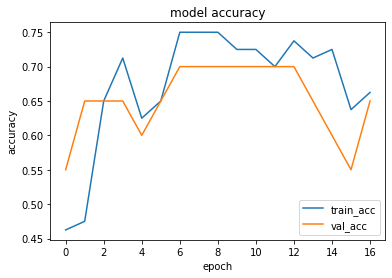

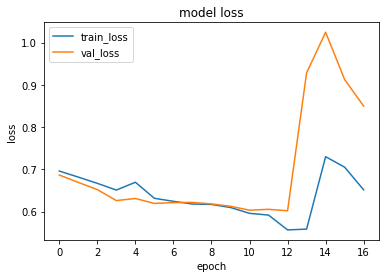

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.4888555]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_3.mov is [[0.5009617]]


1it [00:00, 12052.60it/s]


prediction for video armflapping_2.mov is [[0.5253523]]


1it [00:00, 15592.21it/s]


prediction for video control_1.mov is [[0.46607494]]


1it [00:00, 14926.35it/s]


prediction for video control_2.mov is [[0.46021074]]


1it [00:00, 16384.00it/s]


prediction for video control_3.mov is [[0.45022145]]
Epoch 1/75
3/3 [==============================] - 1s 213ms/step - loss: 0.6917 - accuracy: 0.4625 - precision_30: 0.5294 - recall_30: 0.5870 - val_loss: 0.7223 - val_accuracy: 0.2000 - val_precision_30: 0.2000 - val_recall_30: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6751 - accuracy: 0.5750 - precision_30: 0.5750 - recall_30: 1.0000 - val_loss: 0.7424 - val_accuracy: 0.3000 - val_precision_30: 0.2222 - val_recall_30: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6679 - accuracy: 0.5875 - precision_30: 0.5823 - recall_30: 1.0000 - val_loss: 0.7790 - val_accuracy: 0.3000 - val_precision_30: 0.2222 - val_recall_30: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6710 - accuracy: 0.6000 - precision_30: 0.5897 - recall_30: 1.0000 - val_loss: 0.7800 - val_accuracy: 0.3000 - val_precision_30: 0.2222 - val_recall_30: 1.0000
Epoch 5/75


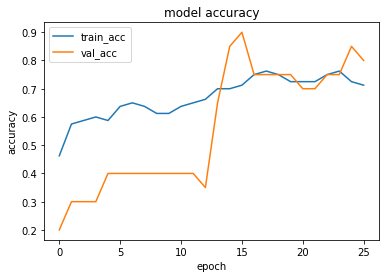

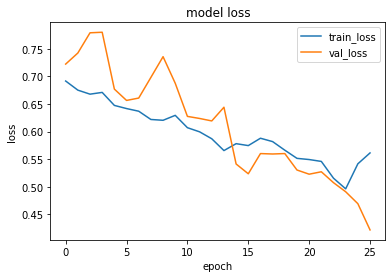

1it [00:00, 13530.01it/s]


prediction for video armflapping_1.mov is [[0.50370836]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_3.mov is [[0.55984664]]


1it [00:00, 14074.85it/s]


prediction for video armflapping_2.mov is [[0.56484246]]


1it [00:00, 14873.42it/s]


prediction for video control_1.mov is [[0.46018234]]


1it [00:00, 15141.89it/s]


prediction for video control_2.mov is [[0.4461356]]


1it [00:00, 16384.00it/s]


prediction for video control_3.mov is [[0.43647033]]
Epoch 1/75
3/3 [==============================] - 1s 199ms/step - loss: 0.6955 - accuracy: 0.4625 - precision_31: 0.3200 - recall_31: 0.2353 - val_loss: 0.7351 - val_accuracy: 0.2000 - val_precision_31: 0.0000e+00 - val_recall_31: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 118ms/step - loss: 0.6823 - accuracy: 0.5750 - precision_31: 0.0000e+00 - recall_31: 0.0000e+00 - val_loss: 0.7634 - val_accuracy: 0.2000 - val_precision_31: 0.0000e+00 - val_recall_31: 0.0000e+00
Epoch 3/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6730 - accuracy: 0.5750 - precision_31: 0.0000e+00 - recall_31: 0.0000e+00 - val_loss: 0.7858 - val_accuracy: 0.2000 - val_precision_31: 0.0000e+00 - val_recall_31: 0.0000e+00
Epoch 4/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6530 - accuracy: 0.5750 - precision_31: 0.0000e+00 - recall_31: 0.0000e+00 - val_loss: 0.8229 - val_accuracy: 0.2000 - val_precisio

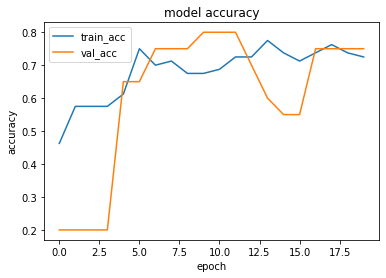

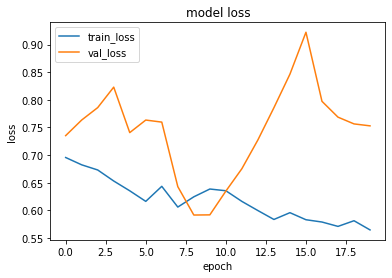

1it [00:00, 14122.24it/s]


prediction for video armflapping_1.mov is [[0.43900344]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_3.mov is [[0.5269418]]


1it [00:00, 15420.24it/s]


prediction for video armflapping_2.mov is [[0.5668951]]


1it [00:00, 13706.88it/s]


prediction for video control_1.mov is [[0.26050073]]


1it [00:00, 14873.42it/s]


prediction for video control_2.mov is [[0.20658758]]


1it [00:00, 14979.66it/s]


prediction for video control_3.mov is [[0.31768125]]
Epoch 1/75
3/3 [==============================] - 1s 196ms/step - loss: 0.6939 - accuracy: 0.3875 - precision_32: 0.3478 - recall_32: 0.1905 - val_loss: 0.6979 - val_accuracy: 0.4500 - val_precision_32: 0.4211 - val_recall_32: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 137ms/step - loss: 0.6864 - accuracy: 0.5375 - precision_32: 0.5397 - recall_32: 0.8095 - val_loss: 0.7065 - val_accuracy: 0.4000 - val_precision_32: 0.4000 - val_recall_32: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 118ms/step - loss: 0.6669 - accuracy: 0.6000 - precision_32: 0.5714 - recall_32: 0.9524 - val_loss: 0.7043 - val_accuracy: 0.4500 - val_precision_32: 0.4211 - val_recall_32: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6438 - accuracy: 0.6125 - precision_32: 0.5821 - recall_32: 0.9286 - val_loss: 0.7333 - val_accuracy: 0.5000 - val_precision_32: 0.4444 - val_recall_32: 1.0000
Epoch 5/75


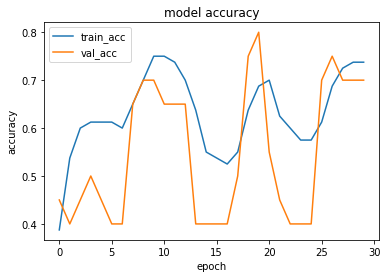

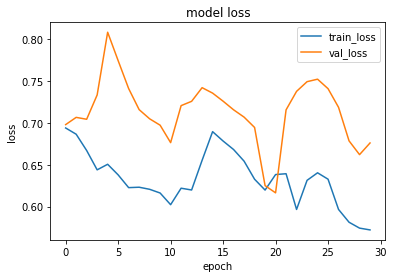

1it [00:00, 14716.86it/s]


prediction for video armflapping_1.mov is [[0.5040397]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_3.mov is [[0.5701258]]


1it [00:00, 13357.66it/s]


prediction for video armflapping_2.mov is [[0.64237994]]


1it [00:00, 14266.34it/s]


prediction for video control_1.mov is [[0.44610345]]


1it [00:00, 14716.86it/s]


prediction for video control_2.mov is [[0.43131956]]


1it [00:00, 14926.35it/s]


prediction for video control_3.mov is [[0.4095728]]
Epoch 1/75
3/3 [==============================] - 1s 214ms/step - loss: 0.6929 - accuracy: 0.5250 - precision_33: 0.5714 - recall_33: 0.1026 - val_loss: 0.6866 - val_accuracy: 0.6500 - val_precision_33: 0.7000 - val_recall_33: 0.6364
Epoch 2/75
3/3 [==============================] - 0s 115ms/step - loss: 0.6882 - accuracy: 0.5375 - precision_33: 0.5185 - recall_33: 0.7179 - val_loss: 0.6771 - val_accuracy: 0.6500 - val_precision_33: 0.6429 - val_recall_33: 0.8182
Epoch 3/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6616 - accuracy: 0.6500 - precision_33: 0.6078 - recall_33: 0.7949 - val_loss: 0.6573 - val_accuracy: 0.7000 - val_precision_33: 0.7778 - val_recall_33: 0.6364
Epoch 4/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6490 - accuracy: 0.7125 - precision_33: 0.7667 - recall_33: 0.5897 - val_loss: 0.6337 - val_accuracy: 0.6000 - val_precision_33: 0.6154 - val_recall_33: 0.7273
Epoch 5/75
3

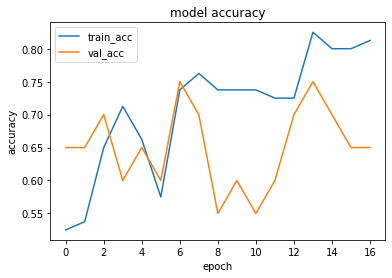

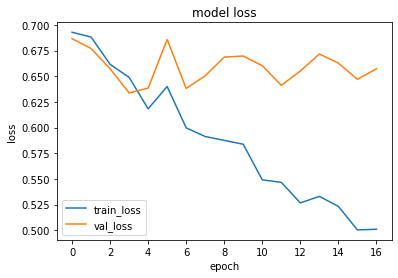

1it [00:00, 12985.46it/s]


prediction for video armflapping_1.mov is [[0.62479913]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.6333848]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_2.mov is [[0.5881462]]


1it [00:00, 14716.86it/s]


prediction for video control_1.mov is [[0.54081744]]


1it [00:00, 13706.88it/s]


prediction for video control_2.mov is [[0.5111457]]


1it [00:00, 14463.12it/s]


prediction for video control_3.mov is [[0.40069062]]


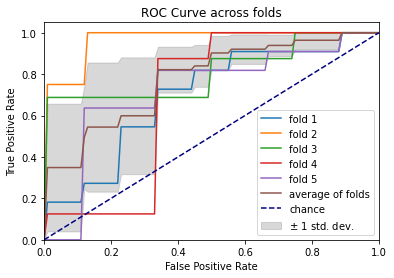

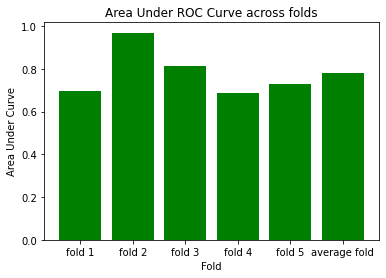

In [59]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[early_stopping, checkpoint])